# GE 461 Introduction to Data Science 2024

# Project 3 – Supervised Learning

### Görkem Kadir Solun 22003214

### Notes

You may need to update the data path.

You may need to update the figure sizes for pyplot.

You may need to update the output path.

### Imports


In [136]:
import os
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(666)

### Loading and Processing the Data

I created raw, centered, and normalized data to use.


In [137]:
# Load the data
# NOTE: This data may need to be configured to the correct path
directory = os.getcwd()
train_data_path = os.path.join(directory, "data\\train1.txt")
test_data_path = os.path.join(directory, "data\\test1.txt")
output_path = os.path.join(directory, "output_gorkem\\")

train_data = np.loadtxt(train_data_path)
test_data = np.loadtxt(test_data_path)
all_data = np.concatenate((train_data, test_data), axis=0)

print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

# Get the mean of the all the data
all_data_mean = np.mean(all_data)
print("Mean: ", all_data_mean)

# Center the data
centered_data = all_data - all_data_mean
centered_train_data = train_data - all_data_mean
centered_test_data = test_data - all_data_mean

# Normalize the data
all_data_min = np.min(centered_data, axis=0)
all_data_max = np.max(centered_data, axis=0)
all_data_range = all_data_max - all_data_min
normalized_data = (centered_data - all_data_min) / all_data_range
normalized_train_data = (centered_train_data - all_data_min) / all_data_range
normalized_test_data = (centered_test_data - all_data_min) / all_data_range

Train Data Shape:  (60, 2)
Test Data Shape:  (41, 2)
Mean:  -14.43713867108911


### Plot Configurations


In [138]:
# Figure size configuration
# NOTE: This is a global configuration for all figures, you may need to adjust this
# NOTE: This change is permanent and will be iterated and applied every time you run this script
""" fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0] * 1.7
fig_size[1] = fig_size[1] * 1.7
plt.rcParams["figure.figsize"] = fig_size """

' fig_size = plt.rcParams["figure.figsize"]\nfig_size[0] = fig_size[0] * 1.7\nfig_size[1] = fig_size[1] * 1.7\nplt.rcParams["figure.figsize"] = fig_size '

# Artificial Neural Network

An ANN with one-dimensional input and output, having either one or no hidden layers.


In [139]:
# An ANN with one-dimensional input and output, having either one or no hidden layers.
class ArtificialNeuralNetwork:
    def __init__(self, hidden_layer_size=0):
        self.hidden_layer_size = hidden_layer_size
        self.output = None

        # Initialize the weights and biases
        # If there is a hidden layer, initialize the weights and biases for both layers
        # If there is no hidden layer, initialize the weights and biases for the input-output layer

        # If there is no hidden layer (input-output)
        if hidden_layer_size == 0:
            self.input_output_weights = np.random.randn(1, 1)
            self.input_output_bias = np.random.randn(1)
        # If there is a hidden layer (input-hidden-output)
        else:
            self.input_hidden_weights = np.random.randn(1, hidden_layer_size)
            self.input_hidden_bias = np.random.randn(hidden_layer_size)
            self.hidden_output_weights = np.random.randn(hidden_layer_size, 1)
            self.hidden_output_bias = np.random.randn(1)

    # Sigmoid function for activation of the neurons in the network
    # sigmoid(X) = 1 / (1 + exp(-X))
    # The output of the sigmoid function is between 0 and 1 for all X
    # This function is used to normalize the output of the neurons
    # and to introduce non-linearity to the network
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    # Derivative of the sigmoid function
    # It is used to calculate the gradient of the loss function
    # with respect to the weights and biases of the network
    # It is used in the backpropagation algorithm to update the weights and biases
    # Sigmoid derivative is calculated as sigmoid(X) * (1 - sigmoid(X))
    def sigmoid_derivative(self, X):
        return X * (1 - X)

    # Sum of squared error loss function
    # The loss function is used to measure the difference between the predicted output
    # and the actual output of the network
    def sum_squared_error(self, y_true, y_pred):
        return np.sum(np.square(y_true - y_pred))

    # Forward pass of the network
    # The forward pass is used to calculate the output of the network
    def forward_pass(self, X):
        # If there is no hidden layer
        # The output of the network is calculated as the input multiplied by the weights and added the bias
        if self.hidden_layer_size == 0:
            self.output = np.dot(X, self.input_output_weights) + self.input_output_bias
        # If there is a hidden layer
        # The output of the network is calculated as the input multiplied by the weights and added the bias
        # then passed through the sigmoid activation function
        # The output of the hidden layer is then multiplied by the weights and added the bias
        else:
            self.hidden_output = self.sigmoid(
                np.dot(X, self.input_hidden_weights) + self.input_hidden_bias
            )
            self.output = (
                np.dot(self.hidden_output, self.hidden_output_weights)
                + self.hidden_output_bias
            )
        return self.output

    # Backward pass of the network
    # The backward pass is used to update the weights and biases of the network
    # It is used to minimize the loss function
    # The backpropagation algorithm is used to calculate the gradients of the loss function
    # with respect to the weights and biases of the network
    # The gradients are then used to update the weights and biases
    # The learning rate is used to control the step size of the updates to the weights and biases
    def backward_pass(self, X, y_true, learning_rate=0.01):
        # Output error is calculated as sum of squared error loss function
        # The derivative of the loss function with respect to the output is calculated as
        output_error = -2 * (y_true - self.output)  # dL/dy

        # If there is no hidden layer
        if self.hidden_layer_size == 0:
            # The derivative of the loss function with respect to the weights and bias of the input-output layer
            # is calculated as the derivative of the loss function with respect to the output
            # multiplied by the derivative of the output with respect to the weights and bias
            # The derivative of the output with respect to the weights is the input
            # The derivative of the output with respect to the bias is 1
            input_output_weights_gradient = np.dot(X.T, output_error)  # dL/dw
            input_output_bias_gradient = np.sum(output_error)  # dL/db

            # The weights and bias of the input-output layer are updated
            self.input_output_weights -= input_output_weights_gradient * learning_rate
            self.input_output_bias -= learning_rate * input_output_bias_gradient

        # If there is a hidden layer
        # The backpropagation algorithm is used to calculate the gradients of the loss function
        # with respect to the weights and biases of the network
        # using the chain rule of calculus
        else:
            # First calculate the gradient of the output-hidden layer, similar to the input-output layer
            hidden_output_weights_gradient = np.dot(
                self.hidden_output.T, output_error
            )  # dL/dw2
            hidden_output_bias_gradient = np.sum(output_error)  # dL/db2

            # Then calculate the gradient of the hidden-input layer
            # by backpropagating the error from the output layer to the hidden layer
            hidden_output_error = np.dot(output_error, self.hidden_output_weights.T)

            # Then calculate the gradient of the hidden layer
            # by multiplying with the derivative of the sigmoid function
            # and the input of the hidden layer
            hidden_output_error *= self.sigmoid_derivative(self.hidden_output)
            input_hidden_weights_gradient = np.dot(X.T, hidden_output_error)  # dL/dw1
            # Bias gradient is the sum of the error
            input_hidden_bias_gradient = np.sum(hidden_output_error)  # dL/db1

            # Finally, update the weights and biases of the network
            # by multiplying the gradients with the learning rate
            self.input_hidden_weights -= learning_rate * input_hidden_weights_gradient
            self.input_hidden_bias -= learning_rate * input_hidden_bias_gradient
            self.hidden_output_weights -= learning_rate * hidden_output_weights_gradient
            self.hidden_output_bias -= learning_rate * hidden_output_bias_gradient

    # Train the network
    # The training process is used to update the weights and biases of the network
    # using the stochastic gradient descent algorithm
    def train(self, X, y, epochs=1000, learning_rate=0.01):
        for epoch in range(epochs):
            # Stochoastic gradient descent
            random_index = np.random.randint(0, len(X))
            X_sample = X[random_index].reshape(-1, 1)
            y_sample = y[random_index].reshape(-1, 1)

            # Forward pass
            output = self.forward_pass(X_sample)

            # Backward pass
            self.backward_pass(X_sample, y_sample, learning_rate)

    # Predict the output of the network
    # The predict function is used to calculate the output of the network
    def predict(self, X):
        return self.forward_pass(X)

    # Plot the data
    def plot(self, X, y, title="Data Plot"):
        plt.scatter(X, y, color="blue", label="Given Data")
        plt.plot(X, self.predict(X), color="red", label="Predicted Data")
        plt.xlabel("X - Input")
        plt.ylabel("Y - Output")
        plt.title(title)
        plt.legend()
        plt.show()

# A - Comparing and Finding Configurations

### No hidden layer


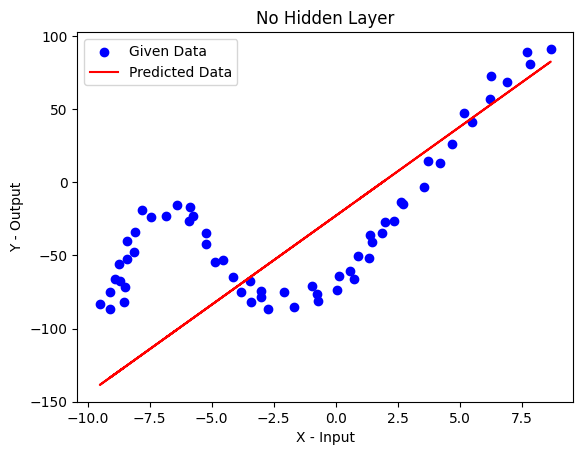

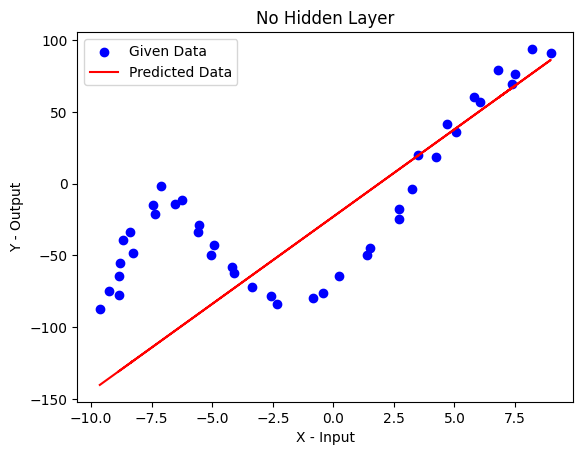

In [140]:
# Train the network with no hidden layer
artificialNeuralNetwork = ArtificialNeuralNetwork(hidden_layer_size=0)

# Prepare the data for training
train_input_no_hidden = train_data[:, 0].reshape(-1, 1)
train_output_no_hidden = train_data[:, 1].reshape(-1, 1)
test_input_no_hidden = test_data[:, 0].reshape(-1, 1)
test_output_no_hidden = test_data[:, 1].reshape(-1, 1)

# Train the network with no hidden layer using the training data
artificialNeuralNetwork.train(
    train_input_no_hidden,
    train_output_no_hidden,
    epochs=100000,
    learning_rate=0.01,
)

# Plot the predicted output of the network with no hidden layer
artificialNeuralNetwork.plot(
    train_input_no_hidden, train_output_no_hidden, title="No Hidden Layer"
)

artificialNeuralNetwork.plot(
    test_input_no_hidden, test_output_no_hidden, title="No Hidden Layer"
)